In [16]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(5997)
tf.random.set_seed(5995)

In [17]:
tf.config.list_physical_devices('GPU')

[]

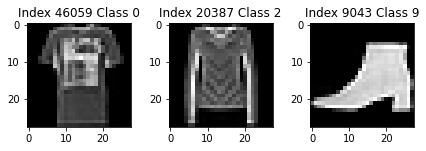

In [18]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

In [19]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


In [20]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [21]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


In [22]:
from keras.layers import Layer
import tensorflow as tf

class CustomBatchNorm(Layer):
    def __init__(self):
        super(CustomBatchNorm, self).__init__()

        self.eps=1e-5

    def build(self, input_shape):
        self.beta = self.add_weight(
            shape=(input_shape[-1]),
            initializer="zeros",
            trainable=True,
        )

        self.gamma = self.add_weight(
            shape=(input_shape[-1]),
            initializer="ones",
            trainable=True,
        )

        self.moving_mean = self.add_weight(
            shape=(input_shape[-1]),
            initializer=tf.initializers.zeros,
            trainable=False)

        self.moving_variance = self.add_weight(
            shape=(input_shape[-1]),
            initializer=tf.initializers.ones,
            trainable=False)

    def get_moving_average(self, statistic, new_value):
        momentum = 0.9
        new_value = statistic * momentum + new_value * (1 - momentum)
        return statistic.assign(new_value)

    def normalise(self, x, x_mean, x_var):
        return (x - x_mean) / tf.sqrt(x_var + 1e-6)

    def call(self, inputs, training):
        if training:
            # assert len(inputs.shape) in (2, 4)
            # if len(inputs.shape) > 2:
            #     axes = [0, 1, 2]
            # else:
            #     axes = [0]
            # mean, var = tf.nn.moments(inputs, axes=axes, keepdims=False)
            
            axes = list(range(len(inputs.shape) - 1))
            batch_mean = tf.reduce_mean(inputs, axes, keepdims=True)
            batch_variance = tf.reduce_mean(tf.math.squared_difference(inputs, tf.stop_gradient(batch_mean)), axes, keepdims=True)
            mean = tf.squeeze(batch_mean, axes)
            var = tf.squeeze(batch_variance, axes)
            self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
            self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
        else:
            mean, var = self.moving_mean, self.moving_variance
            
        inv = tf.cast(tf.math.rsqrt(var + self.eps), inputs.dtype)
        # Scale and shift
        inv *= self.gamma
        Y = inputs * inv + (self.beta - mean * inv)
        return Y

# Pre-activation MLP class

In [23]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X,is_train):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X, is_train)
    else:
      self.y = self.compute_output(X, is_train)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x


 def backward(self, X_train, y_train,is_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train,is_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

    
           
 def compute_output(self, X, is_train):
    """
    Custom method to obtain output tensor during forward pass
    """
    # if is_train == True:
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    # print('Training')
    # #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    z1=CustomBatchNorm()(z1,training=is_train)
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    z2=CustomBatchNorm()(z2,training=is_train)
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    z3=CustomBatchNorm()(z3,training=is_train)
    h3 = tf.nn.relu(z3)
    output = tf.matmul(h3, self.W4) + self.b4
    # else:
    #   X_tf = tf.cast(X, dtype=tf.float32)
    #   z1 = tf.matmul(X_tf, self.W1) + self.b1
    #   z1=CustomBatchNorm()(z1,training=False)
    #   h1 = tf.nn.relu(z1)
      
    #   z2 = tf.matmul(h1, self.W2) + self.b2
    #   z2=CustomBatchNorm()(z2,training=False)
    #   h2 = tf.nn.relu(z2)
      
    #   z3 = tf.matmul(h2, self.W3) + self.b3
    #   z3=CustomBatchNorm()(z3,training=False)
    #   h3 = tf.nn.relu(z3)  
    #   output = tf.matmul(h3, self.W4) + self.b4   

    # Compute output
    
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


## Three Train Runs


Train Accuracy: 0.8589
Number of Epoch = 1 - Average Cross Entropy:= 0.004319722595214843 

Validation Accuracy: 0.8463

Train Accuracy: 0.8782
Number of Epoch = 2 - Average Cross Entropy:= 0.003007080078125 

Validation Accuracy: 0.8631

Train Accuracy: 0.8906
Number of Epoch = 3 - Average Cross Entropy:= 0.0026547885131835936 

Validation Accuracy: 0.8731

Train Accuracy: 0.8970
Number of Epoch = 4 - Average Cross Entropy:= 0.002415638122558594 

Validation Accuracy: 0.8722

Train Accuracy: 0.9053
Number of Epoch = 5 - Average Cross Entropy:= 0.002229101104736328 

Validation Accuracy: 0.8757

Train Accuracy: 0.9112
Number of Epoch = 6 - Average Cross Entropy:= 0.002078346710205078 

Validation Accuracy: 0.8776

Train Accuracy: 0.9192
Number of Epoch = 7 - Average Cross Entropy:= 0.0019297386169433593 

Validation Accuracy: 0.8814

Train Accuracy: 0.9231
Number of Epoch = 8 - Average Cross Entropy:= 0.0017911866760253906 

Validation Accuracy: 0.8800

Train Accuracy: 0.9275
Number o

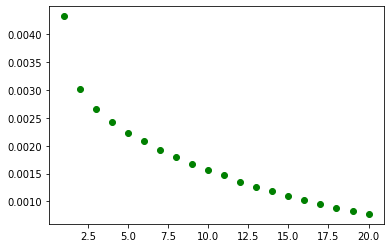

In [9]:
is_train = True

# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs,is_train) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs,is_train)

  preds = mlp_on_cpu.forward(X_train,is_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val,is_train)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


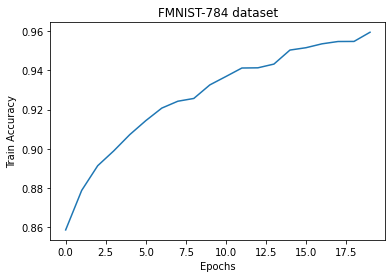

In [ ]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('FMNIST-784 dataset')
plt.plot(acc)


Train Accuracy: 0.8588
Number of Epoch = 1 - Average Cross Entropy:= 0.004318357849121094 

Validation Accuracy: 0.8472

Train Accuracy: 0.8793
Number of Epoch = 2 - Average Cross Entropy:= 0.0030068283081054687 

Validation Accuracy: 0.8619

Train Accuracy: 0.8899
Number of Epoch = 3 - Average Cross Entropy:= 0.0026548342895507814 

Validation Accuracy: 0.8720

Train Accuracy: 0.8973
Number of Epoch = 4 - Average Cross Entropy:= 0.0024157321166992187 

Validation Accuracy: 0.8731

Train Accuracy: 0.9060
Number of Epoch = 5 - Average Cross Entropy:= 0.002231148223876953 

Validation Accuracy: 0.8777

Train Accuracy: 0.9121
Number of Epoch = 6 - Average Cross Entropy:= 0.002078911895751953 

Validation Accuracy: 0.8778

Train Accuracy: 0.9193
Number of Epoch = 7 - Average Cross Entropy:= 0.0019313716125488282 

Validation Accuracy: 0.8813

Train Accuracy: 0.9235
Number of Epoch = 8 - Average Cross Entropy:= 0.001798544921875 

Validation Accuracy: 0.8801

Train Accuracy: 0.9275
Number 

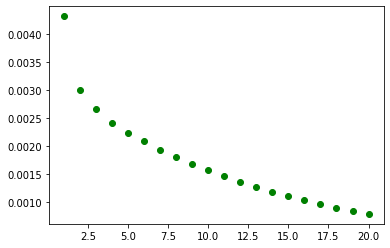

In [24]:
is_train = True

# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5927)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs,is_train) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs,is_train)

  preds = mlp_on_cpu.forward(X_train,is_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val,is_train)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


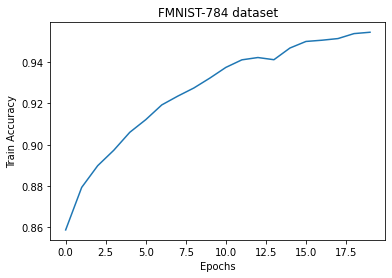

In [25]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('FMNIST-784 dataset')
plt.plot(acc)


Train Accuracy: 0.8584
Number of Epoch = 1 - Average Cross Entropy:= 0.004245240173339844 

Validation Accuracy: 0.8449

Train Accuracy: 0.8801
Number of Epoch = 2 - Average Cross Entropy:= 0.002991414794921875 

Validation Accuracy: 0.8617

Train Accuracy: 0.8905
Number of Epoch = 3 - Average Cross Entropy:= 0.00264223876953125 

Validation Accuracy: 0.8676

Train Accuracy: 0.9007
Number of Epoch = 4 - Average Cross Entropy:= 0.0024050970458984375 

Validation Accuracy: 0.8735

Train Accuracy: 0.9085
Number of Epoch = 5 - Average Cross Entropy:= 0.0022164158630371095 

Validation Accuracy: 0.8784

Train Accuracy: 0.9125
Number of Epoch = 6 - Average Cross Entropy:= 0.0020558448791503908 

Validation Accuracy: 0.8745

Train Accuracy: 0.9193
Number of Epoch = 7 - Average Cross Entropy:= 0.0019050828552246094 

Validation Accuracy: 0.8764

Train Accuracy: 0.9235
Number of Epoch = 8 - Average Cross Entropy:= 0.0017764181518554688 

Validation Accuracy: 0.8762

Train Accuracy: 0.9284
Numb

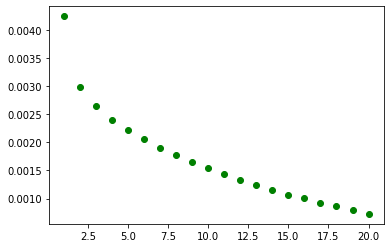

In [27]:
is_train = True

# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5397)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs,is_train) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs,is_train)

  preds = mlp_on_cpu.forward(X_train,is_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val,is_train)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


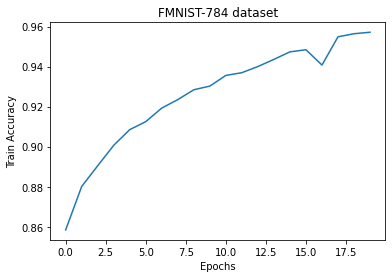

In [28]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('FMNIST-784 dataset')
plt.plot(acc)

## Three Test Runs

In [11]:
# Initialize
is_train = False

test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs,is_train)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test,is_train)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))


Test loss: 0.3806

Test Accuracy: 0.88


In [26]:
# Initialize
is_train = False

test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs,is_train)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test,is_train)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))


Test loss: 0.3842

Test Accuracy: 0.87


In [30]:
# Initialize
is_train = False

test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs,is_train)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test,is_train)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))


Test loss: 0.3813

Test Accuracy: 0.87


# Post-activation MLP class

In [31]:
from keras.layers import Layer
import tensorflow as tf

class CustomBatchNorm(Layer):
    def __init__(self):
        super(CustomBatchNorm, self).__init__()

        self.eps=1e-5

    def build(self, input_shape):
        self.beta = self.add_weight(
            shape=(input_shape[-1]),
            initializer="zeros",
            trainable=True,
        )

        self.gamma = self.add_weight(
            shape=(input_shape[-1]),
            initializer="ones",
            trainable=True,
        )

        self.moving_mean = self.add_weight(
            shape=(input_shape[-1]),
            initializer=tf.initializers.zeros,
            trainable=False)

        self.moving_variance = self.add_weight(
            shape=(input_shape[-1]),
            initializer=tf.initializers.ones,
            trainable=False)

    def get_moving_average(self, statistic, new_value):
        momentum = 0.9
        new_value = statistic * momentum + new_value * (1 - momentum)
        return statistic.assign(new_value)

    def normalise(self, x, x_mean, x_var):
        return (x - x_mean) / tf.sqrt(x_var + 1e-6)

    def call(self, inputs, training):
        if training:
            # assert len(inputs.shape) in (2, 4)
            # if len(inputs.shape) > 2:
            #     axes = [0, 1, 2]
            # else:
            #     axes = [0]
            # mean, var = tf.nn.moments(inputs, axes=axes, keepdims=False)
            
            axes = list(range(len(inputs.shape) - 1))
            batch_mean = tf.reduce_mean(inputs, axes, keepdims=True)
            batch_variance = tf.reduce_mean(tf.math.squared_difference(inputs, tf.stop_gradient(batch_mean)), axes, keepdims=True)
            mean = tf.squeeze(batch_mean, axes)
            var = tf.squeeze(batch_variance, axes)
            self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
            self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
        else:
            mean, var = self.moving_mean, self.moving_variance
            
        inv = tf.cast(tf.math.rsqrt(var + self.eps), inputs.dtype)
        # Scale and shift
        inv *= self.gamma
        Y = inputs * inv + (self.beta - mean * inv)
        return Y

In [32]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X,is_train):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X, is_train)
    else:
      self.y = self.compute_output(X, is_train)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x


 def backward(self, X_train, y_train,is_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train,is_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

    
           
 def compute_output(self, X, is_train):
    """
    Custom method to obtain output tensor during forward pass
    """
    if is_train == True:
    # Cast X to float32
      X_tf = tf.cast(X, dtype=tf.float32)
      # print('Training')
      # #X_tf = X
      
      # Compute values in hidden layers
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      h1 = tf.nn.relu(z1)
      h1=CustomBatchNorm()(h1,training=True)
      
      z2 = tf.matmul(h1, self.W2) + self.b2
      h2 = tf.nn.relu(z2)
      h2=CustomBatchNorm()(h2,training=True)
      
      z3 = tf.matmul(h2, self.W3) + self.b3
      h3 = tf.nn.relu(z3)
      h3=CustomBatchNorm()(h3,training=True)

      output = tf.matmul(h3, self.W4) + self.b4
    else:
      X_tf = tf.cast(X, dtype=tf.float32)
      # #X_tf = X
      
      # Compute values in hidden layers
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      h1 = tf.nn.relu(z1)
      h1=CustomBatchNorm()(h1,training=False)
      
      z2 = tf.matmul(h1, self.W2) + self.b2
      h2 = tf.nn.relu(z2)
      h2=CustomBatchNorm()(h2,training=False)
      
      z3 = tf.matmul(h2, self.W3) + self.b3
      h3 = tf.nn.relu(z3)
      h3=CustomBatchNorm()(h3,training=False)

      output = tf.matmul(h3, self.W4) + self.b4   

    # Compute output
    
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


## Three Train Run


Train Accuracy: 0.8621
Number of Epoch = 1 - Average Cross Entropy:= 0.004060298461914062 

Validation Accuracy: 0.8511

Train Accuracy: 0.8793
Number of Epoch = 2 - Average Cross Entropy:= 0.0029246661376953124 

Validation Accuracy: 0.8632

Train Accuracy: 0.8910
Number of Epoch = 3 - Average Cross Entropy:= 0.002592463684082031 

Validation Accuracy: 0.8725

Train Accuracy: 0.9001
Number of Epoch = 4 - Average Cross Entropy:= 0.0023688546752929688 

Validation Accuracy: 0.8759

Train Accuracy: 0.9034
Number of Epoch = 5 - Average Cross Entropy:= 0.0021788693237304686 

Validation Accuracy: 0.8758

Train Accuracy: 0.9101
Number of Epoch = 6 - Average Cross Entropy:= 0.00203756103515625 

Validation Accuracy: 0.8781

Train Accuracy: 0.9137
Number of Epoch = 7 - Average Cross Entropy:= 0.0019003076171875 

Validation Accuracy: 0.8791

Train Accuracy: 0.9182
Number of Epoch = 8 - Average Cross Entropy:= 0.00177418212890625 

Validation Accuracy: 0.8783

Train Accuracy: 0.9200
Number of

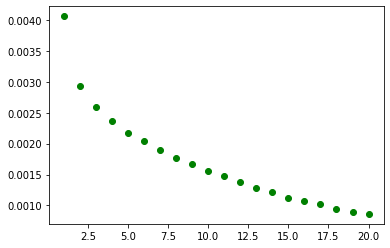

In [ ]:
is_train = True

# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs,is_train) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs,is_train)

  preds = mlp_on_cpu.forward(X_train,is_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val,is_train)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


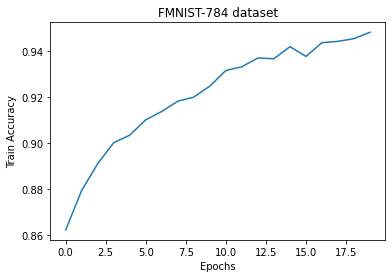

In [ ]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('FMNIST-784 dataset')
plt.plot(acc)


Train Accuracy: 0.8640
Number of Epoch = 1 - Average Cross Entropy:= 0.0039915853881835935 

Validation Accuracy: 0.8543

Train Accuracy: 0.8821
Number of Epoch = 2 - Average Cross Entropy:= 0.0028924566650390623 

Validation Accuracy: 0.8624

Train Accuracy: 0.8931
Number of Epoch = 3 - Average Cross Entropy:= 0.002568109130859375 

Validation Accuracy: 0.8716

Train Accuracy: 0.9012
Number of Epoch = 4 - Average Cross Entropy:= 0.002342761993408203 

Validation Accuracy: 0.8719

Train Accuracy: 0.9096
Number of Epoch = 5 - Average Cross Entropy:= 0.0021560188293457032 

Validation Accuracy: 0.8765

Train Accuracy: 0.9112
Number of Epoch = 6 - Average Cross Entropy:= 0.0020019691467285158 

Validation Accuracy: 0.8759

Train Accuracy: 0.9178
Number of Epoch = 7 - Average Cross Entropy:= 0.0018793385314941407 

Validation Accuracy: 0.8783

Train Accuracy: 0.9226
Number of Epoch = 8 - Average Cross Entropy:= 0.0017511062622070311 

Validation Accuracy: 0.8772

Train Accuracy: 0.9251
Nu

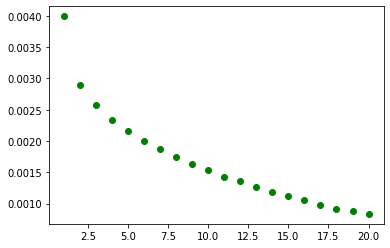

In [33]:
is_train = True

# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5197)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs,is_train) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs,is_train)

  preds = mlp_on_cpu.forward(X_train,is_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val,is_train)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


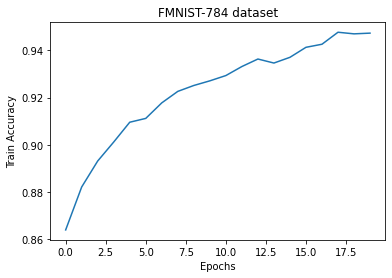

In [34]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('FMNIST-784 dataset')
plt.plot(acc)


Train Accuracy: 0.8613
Number of Epoch = 1 - Average Cross Entropy:= 0.004060337524414062 

Validation Accuracy: 0.8494

Train Accuracy: 0.8805
Number of Epoch = 2 - Average Cross Entropy:= 0.0029275473022460936 

Validation Accuracy: 0.8634

Train Accuracy: 0.8918
Number of Epoch = 3 - Average Cross Entropy:= 0.0025989605712890625 

Validation Accuracy: 0.8728

Train Accuracy: 0.9012
Number of Epoch = 4 - Average Cross Entropy:= 0.002370348663330078 

Validation Accuracy: 0.8794

Train Accuracy: 0.9028
Number of Epoch = 5 - Average Cross Entropy:= 0.0021957432556152343 

Validation Accuracy: 0.8769

Train Accuracy: 0.9094
Number of Epoch = 6 - Average Cross Entropy:= 0.0020424041748046875 

Validation Accuracy: 0.8789

Train Accuracy: 0.9166
Number of Epoch = 7 - Average Cross Entropy:= 0.0019191403198242187 

Validation Accuracy: 0.8823

Train Accuracy: 0.9171
Number of Epoch = 8 - Average Cross Entropy:= 0.001802165985107422 

Validation Accuracy: 0.8794

Train Accuracy: 0.9231
Num

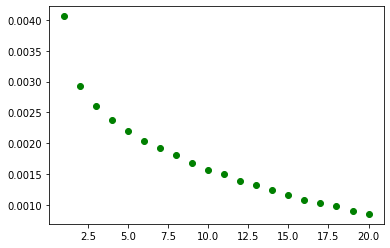

In [36]:
is_train = True

# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5994)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs,is_train) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs,is_train)

  preds = mlp_on_cpu.forward(X_train,is_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val,is_train)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


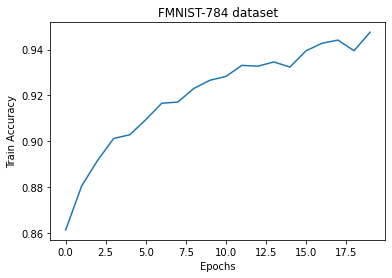

In [37]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('FMNIST-784 dataset')
plt.plot(acc)

## Three Test Runs

In [35]:
# Initialize
is_train = False

test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs,is_train)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test,is_train)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.3775

Test Accuracy: 0.87


In [38]:
# Initialize
is_train = False
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs,is_train)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test,is_train)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.3847

Test Accuracy: 0.87


In [39]:
# Initialize
is_train = False

test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs,is_train)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test,is_train)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.3847

Test Accuracy: 0.87
